In [1]:
from image_explainer import *
from utils import *
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import numpy as np
import pandas as pd
import torch
import torchvision
from sklearn.manifold import TSNE
from modules import *
import random
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from sklearn.cluster import SpectralClustering

/user/cs.aau.dk/em63by/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
embeds = load_inception_embeds()
X_train = torch.tensor(embeds["X_train"])
Y_train = torch.tensor(embeds["Y_train"])

# X_test =  torch.cat((torch.tensor(embeds["X_test"]), torch.tensor(embeds["X_train"])), dim=0)
# Y_test = torch.cat((torch.tensor(embeds["Y_test"]), torch.tensor(embeds["Y_train"])), dim=0)

X_test = torch.tensor(embeds["X_test"])
Y_test = torch.tensor(embeds["Y_test"])

train_set = data.TensorDataset(X_train, Y_train)
test_set = data.TensorDataset(X_test, Y_test)
clf = fit_model(X_train, Y_train)

Using cached Inceptionv3 embeddings: /user/cs.aau.dk/em63by/Influence_Function_Evaluation/Projects/data/dataset_coda.npz


In [3]:
module = LiSSAInfluenceModule(
    model=clf,
    objective=BinClassObjective(),
    train_loader=data.DataLoader(train_set, batch_size=32),
    test_loader=data.DataLoader(test_set, batch_size=32),
    device=DEVICE,
    damp=0.001,
    repeat= 1,
    depth=1800,
    scale= 10,
)
train_idxs = list(range(X_train.shape[0]))

In [ ]:
# Function to generate Es and values for a given T
def generate_influential_samples(t, aide=False):
    if aide:
        pass
    else:
        scaler = MinMaxScaler()
        inf_list=scaler.fit_transform(module.influences(train_idxs=train_idxs, test_idxs=[t]).reshape(-1, 1))
        inf_list=torch.tensor(inf_list.squeeze()).sort(descending=True)
        return {inf_list[1][i].item(): inf_list[0][i].item() for i in range(10)}

# List of T's
points_T = [i for i in range(len(Y_test))]

# Create influential_samples dictionary automatically
influential_samples = {t: generate_influential_samples(t) for t in tqdm(points_T)}

# Print the generated dictionary
# for t, es in influential_samples.items():
#     print(f"{t}: {es}")

# Create a bipartite graph
G = nx.Graph()

# Dummy image tensors for illustration

# Create a bipartite graph
G = nx.Graph()

# Add nodes from sets T and E with vector representations and image tensors
for i in points_T:
    G.add_node(i, bipartite=0)

for point, samples in influential_samples.items():
    for sample, score in samples.items():
        G.add_node(f'ex-{sample}', bipartite=1)
        G.add_edge(point, f'ex-{sample}', weight=score)

# Save the graph as data
nx.write_gpickle(G, 'bipartite_graph.pkl')        

# Visualize the graph
# plt.figure(figsize=(12, 8))
# pos = nx.spring_layout(G, seed=42)
# # Draw nodes
# nx.draw_networkx_nodes(G, pos, nodelist=points_T, node_color='b', label='Points T', node_size=100)
# nx.draw_networkx_nodes(G, pos, nodelist=list((sample for samples in influential_samples.values() for sample in samples)), node_color='r', label='Samples E', node_size=100)

# # Draw edges with influence scores as labels
# nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
# edge_labels = {(point, sample): f"{score:.2f}" for point, samples in influential_samples.items() for sample, score in samples.items()}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# # Display the graph
# plt.title("Bipartite Graph of Points T and Influential Samples E")
# plt.legend()
# plt.axis('off')
# plt.show()

In [4]:
G = nx.read_gpickle('bipartite_graph.pkl')

In [5]:
points_T = [i for i in range(len(Y_test[:200]))]

In [ ]:
points_T

In [10]:
from sklearn.cluster import KMeans

# Project the bipartite graph onto the points_T set
points_T_graph = nx.bipartite.weighted_projected_graph(G, points_T)

# Get the adjacency matrix and convert it to a numpy array
adjacency_matrix = nx.to_numpy_array(points_T_graph)

# Specify the desired number of communities
num_communities_desired = 5

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_communities_desired, random_state=42)
community_assignments = kmeans.fit_predict(adjacency_matrix)



In [6]:
import community
# Project the bipartite graph onto the points_T set
points_T_graph = nx.bipartite.weighted_projected_graph(G, points_T)

# Apply Louvain community detection algorithm
partition = community.best_partition(points_T_graph, weight='weight')

# Extract communities
communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = []
    communities[community_id].append(node)

In [7]:
len(communities)

3

In [12]:
point_communities = {point: community_id for point, community_id in zip(points_T, community_assignments)}

# Print points with their corresponding communities
for point, community_id in point_communities.items():
    print(f"Point {point} belongs to Community {community_id}")


Point 0 belongs to Community 1
Point 1 belongs to Community 1
Point 2 belongs to Community 1
Point 3 belongs to Community 3
Point 4 belongs to Community 4
Point 5 belongs to Community 1
Point 6 belongs to Community 1
Point 7 belongs to Community 0
Point 8 belongs to Community 2
Point 9 belongs to Community 3
Point 10 belongs to Community 0
Point 11 belongs to Community 4
Point 12 belongs to Community 0
Point 13 belongs to Community 4
Point 14 belongs to Community 4
Point 15 belongs to Community 0
Point 16 belongs to Community 4
Point 17 belongs to Community 1
Point 18 belongs to Community 3
Point 19 belongs to Community 0
Point 20 belongs to Community 1
Point 21 belongs to Community 3
Point 22 belongs to Community 0
Point 23 belongs to Community 0
Point 24 belongs to Community 1
Point 25 belongs to Community 3
Point 26 belongs to Community 3
Point 27 belongs to Community 1
Point 28 belongs to Community 3
Point 29 belongs to Community 2
Point 30 belongs to Community 0
Point 31 belongs t

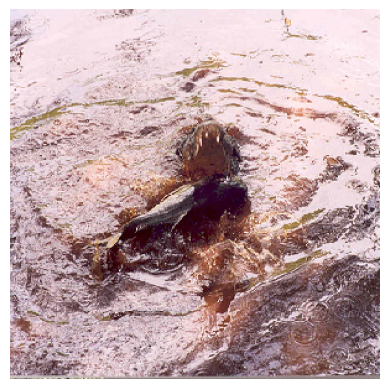

In [16]:
image = captioned_image(clf, embeds, 'test', 6)
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:


# Filter nodes and get the biadjacency matrix for points_T
points_T_nodes = [node for node in G.nodes if node in points_T]
biadjacency_mat = bipartite.biadjacency_matrix(G, row_order=points_T_nodes)

# Convert to a regular adjacency matrix
adjacency_mat = biadjacency_mat @ biadjacency_mat.T

# Calculate cosine similarity between node attributes for points_T
node_attributes = {node: X_test[node].numpy() for node in G.nodes if node in points_T_nodes}
attribute_matrix = np.array([node_attributes[node] for node in points_T_nodes])
cosine_sim_matrix = cosine_similarity(attribute_matrix, attribute_matrix)

# Combine adjacency matrix and cosine similarity matrix
combined_matrix = adjacency_mat + cosine_sim_matrix

# Perform spectral clustering using scikit-learn
num_communities = 10  # Adjust as needed
spectral = SpectralClustering(n_clusters=num_communities, affinity='precomputed', random_state=42)
communities = spectral.fit_predict(combined_matrix)

# df = pd.DataFrame({'Node': points_T_nodes, 'Community': communities}, index=None)

# # Save the DataFrame to a CSV file
# df.to_csv('communities.csv', index=False)

In [ ]:
clf(X_test[156].unsqueeze(0))

In [ ]:
df=pd.read_csv('communities.csv')


In [ ]:
image = captioned_image(clf, embeds, 'test', 156)
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
df[df['Community']==5]

In [ ]:
module.influences(train_idxs=train_idxs, test_idxs=[61]).argsort(descending=True)[:10]

In [ ]:
module.influences(train_idxs=train_idxs, test_idxs=[16]).argsort(descending=True)[:10]

In [ ]:
module.influences(train_idxs=train_idxs, test_idxs=[156]).argsort(descending=True)[:10]

In [ ]:
# Build a dataframe with X-trains with threir corresponding influence scores and similarity
def df_construct(test_idx, train_idxs):
    influences = module.influences(train_idxs=train_idxs, test_idxs=[test_idx])
    
    similarity=[cosine_similarity(X_test[test_idx].numpy().reshape(1,-1), X_train[i].numpy().reshape(1, -1)).item()
               for i in range(len(X_train))]
    squared_diff = (clf(X_train.to(DEVICE)) - Y_train.to(DEVICE))**2

    # Calculate the RMS error for each training point
    train_losses = torch.sqrt(squared_diff)+

    # Detach the tensor from the computation graph
    train_losses = train_losses.detach().requires_grad_(False)
    relatif=influences/train_losses

    data = {'Influence': influences.reshape(-1).tolist(), "Relatif":relatif, 'Similarity': similarity, 'Y_train':Y_train.tolist(), 
            'X_train':X_train.numpy().tolist()}
    df = pd.DataFrame(data)
    return df

# test_idx = 91
# df = df_construct(test_idx, train_idxs)

In [ ]:
df.sort_values("Influence")